In [ ]:
#Implement a program on Adversarial training, tangent distance, tangent prop and tangent classifier. [Any three to be implemented].
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Layer
import matplotlib.pyplot as plt

In [ ]:
#load the mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [ ]:
subset = 1000
#Normalize pixel values of the images from the range [0, 255] to [0, 1].
x_train = x_train[:subset]/255.0
y_train = y_train[:subset]
x_test = x_test[:200]/255.0
y_test = y_test[:200]

In [ ]:
#model for adversarial training
def create_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
#Generate adversarial examples
def generate_adversarial_examples(model, x, y, epsilon=0.1):
    np.random.seed(100)
    perturbations=np.sign(np.random.randn(*x.shape))
    x_adv=x+epsilon*perturbations
    return np.clip(x_adv,0,1)


In [ ]:
class tangentprop(Layer):
    def call(self,x):
        perturbations= tf.random.normal(shape=tf.shape(x), stddev=0.1)
        return x+perturbations

def tangent_dist(x1,x2):
    return np.linalg.norm(x1-x2)

#train the model with adversarial training and plot the loss graph
model = create_model()
x_adv=generate_adversarial_examples(model,x_train,y_train)
x_comb=np.concatenate((x_train,x_adv))
y_comb=np.concatenate((y_train,y_train))
history_adv = model.fit(x_comb, y_comb, epochs=5, validation_data=(x_test, y_test), verbose=0)

#apply tanget prop to the model
model_tangent = create_model()
model_tangent.add(tangentprop())
history_tangent = model_tangent.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), verbose=0)
loss, acc_tangent_prop= model_tangent.evaluate(x_test, y_test,verbose=0)
print(f'Tangent prop accuracy: {acc_tangent_prop*100}%')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Tangent prop accuracy: 76.49999856948853%


In [ ]:
#tangent dist classifier
def classify_with_tangent_dist(x_train, y_train, x_test):
    x_train_flat=x_train.reshape(x_train.shape[0],-1)
    x_test_flat=x_test.reshape(x_test.shape[0],-1)
    y_pred=[]
    for x in x_test_flat:
        dist=[tangent_dist(x,x_train_flat[i]) for i in range(len(x_train_flat))]
        y_pred.append(y_train[np.argmin(dist)])
    return np.array(y_pred)

In [ ]:
y_pred=classify_with_tangent_dist(x_train,y_train,x_test)
acc_tangent_dist=np.mean(y_pred==y_test)
print(f'Tangent dist Classifier accuracy: {acc_tangent_dist*100}%')

Tangent dist Classifier accuracy: 85.0%


In [ ]:
#evaluate the adversarially trained model with tangent prop
loss, acc_tangent_prop= model_tangent.evaluate(x_test, y_test,verbose=0)
print(f'Adversarially trained model with Tangent prop accuracy: {acc_tangent_prop*100}%')

Adversarially trained model with Tangent prop accuracy: 76.49999856948853%


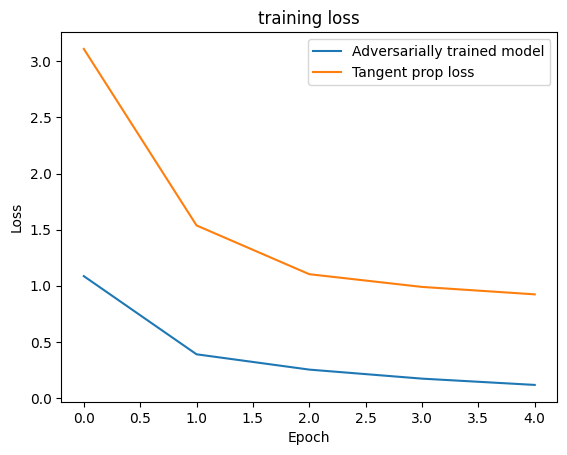

In [ ]:
#plot the loss graph
plt.plot(history_adv.history['loss'], label='Adversarially trained model')
plt.plot(history_tangent.history['loss'], label='Tangent prop loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("training loss")
plt.legend()
plt.show()